# 3.1 MOO for 2D vector fields

In [1]:
import numpy as np

from cyclops.object_reader import PickleManager
from cyclops.plotting import PlotManager

# Load any objects necessary
pickle_manager = PickleManager()
graph_manager = PlotManager()
true_temp_field = pickle_manager.read_file('results/disp_plane_field.pickle')
grid = pickle_manager.read_file('results/disp_plane_points.pickle')

field_bounds = true_temp_field.get_bounds()
sensor_bounds = field_bounds+np.array([[1, 1], [-1, -1]])*0.002

In [2]:
from cyclops.fields import VectorField
from cyclops.regressors import RBFModel
from cyclops.sensor_suite import SensorSuite, SymmetryManager
from cyclops.sensors import RoundSensor

# Setup the symmetry
symmetry_manager = SymmetryManager()
symmetry_manager.set_2D_x(np.mean(field_bounds[:, 0]))

# Setup the sensor suite
def f(x): return np.zeros(x.shape)
sensor = RoundSensor(0, f, 0.1, np.array([[-5e10, -5e10, -5e10], [5e10, 5e10, 5e10]]), 0, 2)
sensors = np.array([sensor]*5)

sensor_suite = SensorSuite(
    VectorField(RBFModel, field_bounds), 
    sensors,
    symmetry=[symmetry_manager.reflect_2D_horiz]
)

In [3]:
from cyclops.experiment import Experiment
from cyclops.optimisers import NSGA2Optimiser

# Setup the experiment
optimiser = NSGA2Optimiser('00:00:10')
experiment = Experiment(
    true_temp_field,
    grid,
    optimiser
)
experiment.plan_moo(
    sensor_suite,
    sensor_bounds,
    repetitions=10,
    loss_limit=3e-11
)
res = experiment.design()

# Display and save the results
for i, setup in enumerate(res.X):
    pickle_manager.save_file(f"results/disp_2D_{str(i)}.pickle", setup.reshape(-1, true_temp_field.get_dim()))

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       40 |      1 |             - |             -
     2 |       50 |      1 |  0.000000E+00 |             f
     3 |       60 |      1 |  0.000000E+00 |             f
     4 |       70 |      1 |  0.000000E+00 |             f
     5 |       80 |      1 |  0.000000E+00 |             f
     6 |       90 |      1 |  0.000000E+00 |             f
     7 |      100 |      1 |  9.128955E-12 |             f
     8 |      110 |      1 |  9.458945E-12 |             f
     9 |      120 |      1 |  9.458945E-12 |             f


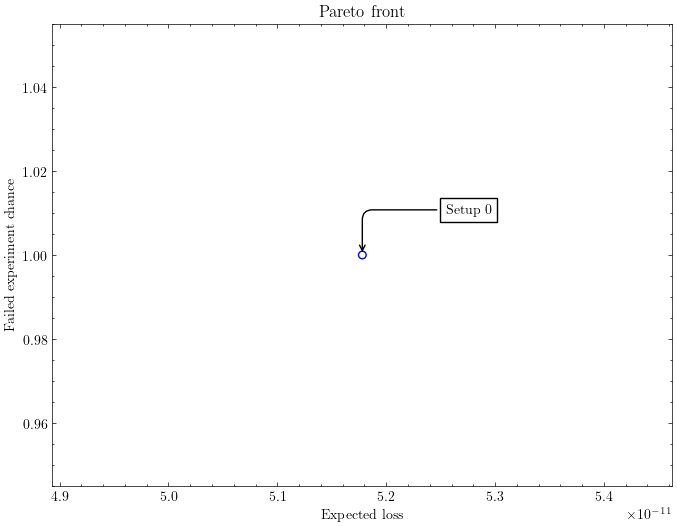

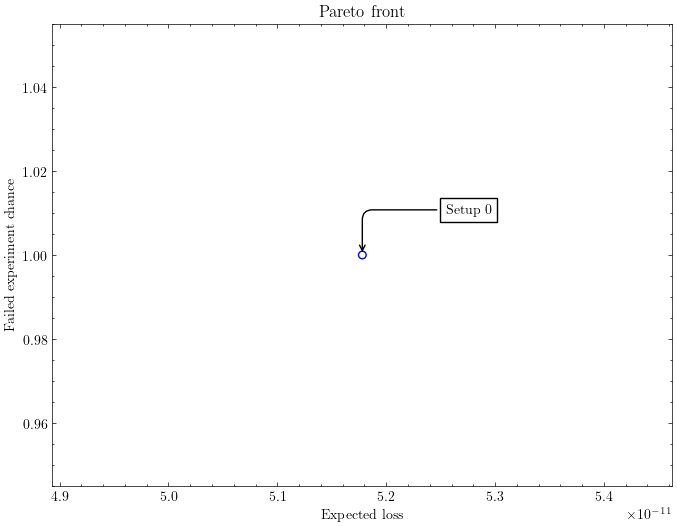

In [4]:
graph_manager.build_pareto(res.F)
graph_manager.draw()

graph_manager.build_pareto(res.F)

display_str = input('Enter setup to display [Q to quit]: ')
while display_str.isnumeric():
    proposed_layout, true_disps, model_disps, sensor_vals = experiment.get_SOO_plotting_arrays(res.X[int(display_str)])
    print('\nLoss:', experiment.calc_moo_loss(res.X[int(display_str)]))
    mag_true_disps = np.linalg.norm(true_disps, axis=1).reshape(-1, 1)
    mag_model_disps = np.linalg.norm(model_disps, axis=1).reshape(-1, 1)
    mag_sensor_vals = np.linalg.norm(sensor_vals, axis=1).reshape(-1, 1)

    graph_manager.build_2D_compare(
        grid,
        proposed_layout,
        mag_true_disps,
        mag_model_disps
    )
    graph_manager.draw()
    display_str = input('Enter setup to display [Q to quit]: ')